#### BBM446- ASSIGNMENT 3
#### EMRE CAN ŞAHİN -2210356146 
https://drive.google.com/drive/folders/17AWeOwYi7mOXupYJf1s3p3Wu7kT9b_Ch?usp=sharing

In [1]:
import numpy as np
from skimage import io
import cv2
import scipy.interpolate as interpolate
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy import interpolate
from scipy import signal


#### 1. BILATERAL FILTERING 

In [19]:
def bilateral_filter(im_am, im_f, sigma_range=0.25, sigma_spatial=2, gaussian_k=0):

    

    im1 = im_am
    im2 = im_f

    lambda1 = 0.0001
    minI = min(im2.flatten()-lambda1)
    maxI = max(im2.flatten()+lambda1)
    nb_seg = np.ceil((maxI - minI)/sigma_range)
    k = gaussian_k

    J = []
    for j in range(int(nb_seg)):
    
        ij = minI + j*(maxI - minI)/nb_seg
        Gj = np.exp(-((im2-ij)**2)/(2*sigma_range**2))
        Kj = cv2.GaussianBlur(Gj, (k,k), sigma_spatial)
    
        Hj = Gj*im1
        Hj = cv2.GaussianBlur(Hj, (k,k), sigma_spatial)
        Jj = Hj/Kj
        J.append(Jj)

    J = np.array(J)
    print(J.shape)
    J = J.transpose(1,2,0,3)
    h,w,_,_ = J.shape
    y = np.arange(0, h)
    x = np.arange(0, w)
    xx, yy = np.meshgrid(x, y)
    r = interpolate.interpn((np.arange(0,h),
                        np.arange(0,w),
                        np.arange(J.shape[2])), J[:,:,:,0], (yy, xx, im1[:,:,0]))
    g = interpolate.interpn((np.arange(0,h),
                        np.arange(0,w),
                        np.arange(J.shape[2])), J[:,:,:,1], (yy, xx, im1[:,:,1]))
    b = interpolate.interpn((np.arange(0,h),
                            np.arange(0,w),
                            np.arange(J.shape[2])), J[:,:,:,2], (yy, xx, im1[:,:,2]))
    Ji = np.stack([r,g,b], axis=2)

    Ji = (Ji-Ji.min())/(Ji.max()-Ji.min())

    return Ji

def bilateral_filtering_pipeline(F, A, sigma_r, sigma_s, t_shadow):
    F_base = np.zeros_like(F)
    for c in range(F_base.shape[-1]):
        F_base[...,c] = PiecewiseBilateral(F[...,c], sigma_r, sigma_s)

    A_base = np.zeros_like(A)
    for c in range(A_base.shape[-1]):
        A_base[...,c] = PiecewiseBilateral(A[...,c], sigma_r, sigma_s)

    A_NR = np.zeros_like(A)
    for c in range(A_NR.shape[-1]):
        A_NR[...,c] = JointBilateral(A[...,c], F[...,c], sigma_r, sigma_s)


    F_lin = inverse_gamma(F)
    A_lin = inverse_gamma(A)
    M = create_mask(F_lin, A_lin, t_shadow)

    A_detail = detail_transfer(A_NR, F, F_base)

    A_Final = ((1-M) * A_detail) + (M * A_base)
    return np.clip(A_Final,0,1)

def PiecewiseBilateral(I, sigma_r, sigma_s):
    lambda_val = 0.01
    eps = 1e-32
    I_min = np.min(I) - lambda_val
    I_max = np.max(I) + lambda_val
    nb_segments = int(np.ceil((I_max - I_min) / sigma_r))

   
    J_img = np.zeros((I.shape[0], I.shape[1], nb_segments))

    for j in range(nb_segments):
        
        i_j = I_min + j * (I_max - I_min) / nb_segments
        G_j = np.exp(- (I - i_j) ** 2 / (2 * sigma_r ** 2))
        K_j = cv2.GaussianBlur(G_j, (0, 0), sigma_s)
        H_j = G_j * I
        H_j_star = cv2.GaussianBlur(H_j, (0, 0), sigma_s)
        J_j = H_j_star / (K_j + eps)
        J_img[..., j] = J_j

    fx, fy = np.meshgrid(np.arange(I.shape[1]), np.arange(I.shape[0]))
    interpGrid = [np.arange(x) for x in J_img.shape]
    interpPoints = np.stack((fy.flatten(), fx.flatten()), axis=-1)
    interpPoints = np.concatenate((interpPoints, np.zeros((interpPoints.shape[0], 1))), axis=-1)
    interpValues = interpolate.interpn(interpGrid, J_img, interpPoints)

    return interpValues.reshape(I.shape)
    
def detail_transfer1(im_f, im_am):

    im_f_bf = bilateral_filter(im_f, im_f, sigma_range=0.5, sigma_spatial=1, gaussian_k=3)
    im_jbf = bilateral_filter(im_am, im_f, sigma_range=0.25, sigma_spatial=1, gaussian_k=0)

    epsi = 1e-8

    out = im_jbf*(im_f + epsi)/(im_f_bf + epsi)
    out = np.clip(out, 0, 1)
    return out
    
def detail_transfer(A_NR, F, F_base):
    eps = 0.0001
    return A_NR * (F + eps) / (F_base + eps)

def JointBilateral(A, F, sigma_r, sigma_s):
    
    w = sigma_s
    x, y = np.meshgrid(np.arange(-w, w + 1), np.arange(-w, w + 1))
    kernel_spatial = np.exp(-(x**2 + y**2) / (2 * sigma_s**2))

    
    padded_no_flash = np.pad(A, w, mode='symmetric')
    padded_flash = np.pad(F, w, mode='symmetric')

    filtered = np.zeros_like(A)
    for i in range(w, A.shape[0] + w):
        for j in range(w, A.shape[1] + w):
            
            kernel_range = np.exp(-((padded_flash[i-w:i+w+1, j-w:j+w+1] - padded_flash[i, j])**2) / (2 * sigma_r**2))
            
            numerator = np.sum(kernel_spatial * kernel_range * padded_no_flash[i-w:i+w+1, j-w:j+w+1])
            denominator = np.sum(kernel_spatial * kernel_range)
            filtered[i-w, j-w] = numerator / denominator

    return filtered

def shadow_mask(F, A, t_shadow):
    return np.where((F - A) <= t_shadow, 1, 0)

def create_mask(F, A, t_shadow):
    M_shadow = (F - A <= t_shadow).astype(np.uint8)

    hsv = cv2.cvtColor(F.astype(np.float32), cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    M_specular = (v >= 0.95 * np.max(v)).astype(np.uint8)
    M_specular = M_specular[:, :, np.newaxis]

    return M_shadow * M_specular

def inverse_gamma(img):
    img_copy = np.copy(img)
    img_copy[img_copy <= 0.0404482] = img_copy[img_copy <= 0.0404482] / 12.92
    img_copy[img_copy > 0.0404482] = ((img_copy[img_copy > 0.0404482] + 0.055) / 1.055) ** 2.4
    return np.clip(img_copy, 0, 1)

def get_mask(im_f, im_am):

    def gamma_correction(im):

        out = im.copy()
        out[np.where(out<=0.0404482)] = out[np.where(out<=0.0404482)]/12.92
        out[np.where(out>0.0404482)] = ((out[np.where(out>0.0404482)]+0.055)/1.055)**2.4

        return out
        

    F_lin = gamma_correction(im_f)
    A_lin = gamma_correction(im_am)
    
    M = np.zeros(F_lin.shape)
    M[np.where(F_lin - A_lin <= 0.85)] = 1
    return M

def masking(im_f, im_am):

    M = get_mask(im_f, im_am)
    im_detail = detail_transfer1(im_f, im_am)
    im_am_bf = bilateral_filter(im_am, im_am, sigma_range=0.25, sigma_spatial=1, gaussian_k=0)

    out = im_am_bf*M + im_detail*(1-M)
    out = np.clip(out, 0, 1)
    return out, im_detail, M

####  1.1  Implement bilateral filtering


(5, 1224, 1532, 3)


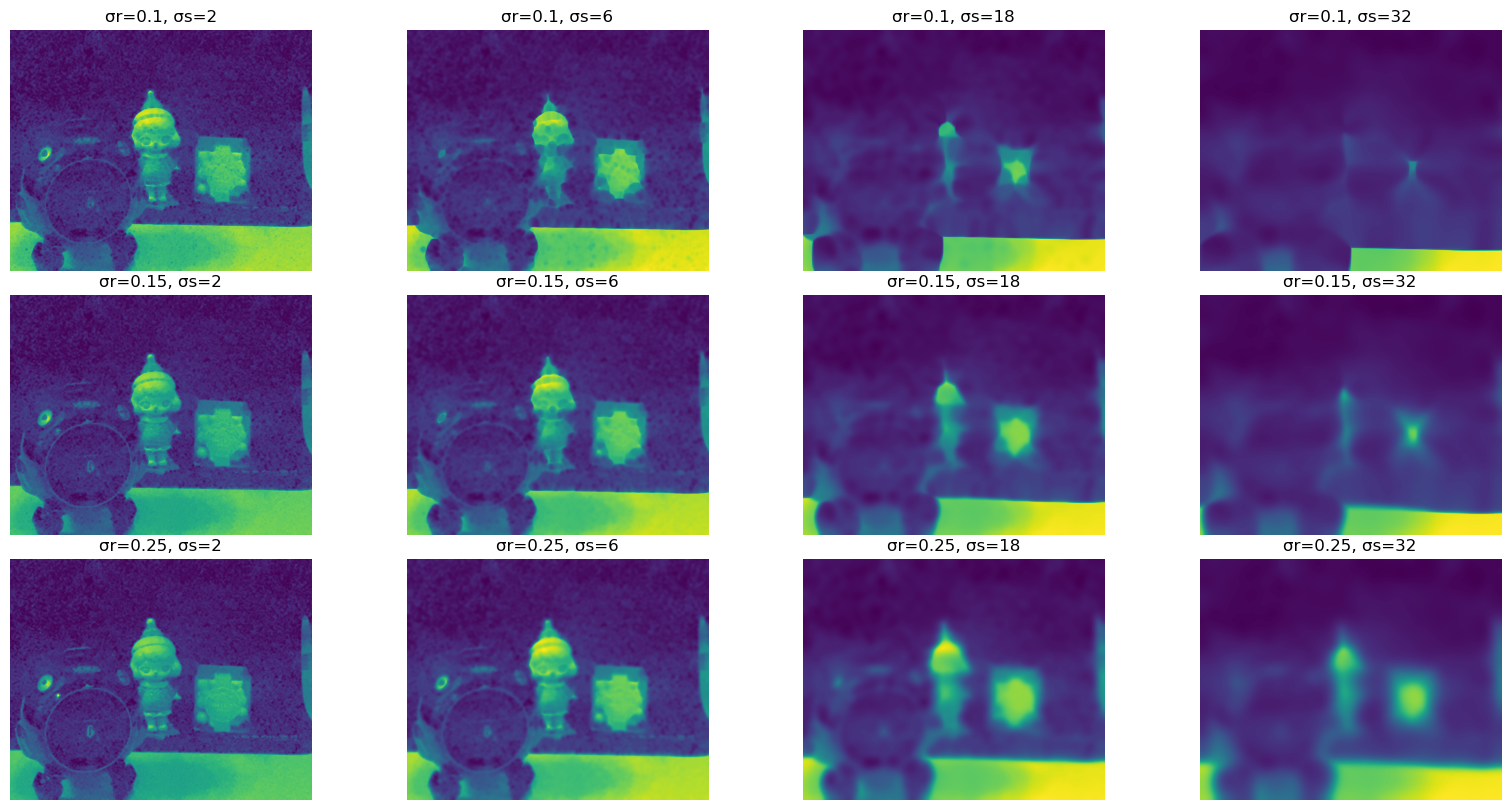

(5, 1224, 1532, 3)


In [34]:
im1 = io.imread('data/camera/nonflash/1.jpg')
im1 = (im1-im1.min())/(im1.max()-im1.min())
im2 = io.imread('data/camera/flash/1.jpg')
im2 = (im2-im2.min())/(im2.max()-im2.min())

out = bilateral_filter(im1, im1)

# Normalize et (0-1 aralığına getir)
out_norm = (out - out.min()) / (out.max() - out.min())

# uint8'e çevir
out_uint8 = img_as_ubyte(out_norm)

# Görüntüyü kaydet
io.imsave('bilateral.png', out_uint8)

# Görüntüyü göster
#io.imshow(out)
#io.show()

image = im1[...,0]    # use only the red channel
sigma_r_list = [0.1, 0.15, 0.25] 
sigma_s_list = [2, 6, 18, 32]

fig, axes = plt.subplots(len(sigma_r_list), len(sigma_s_list), figsize=(20, 10))

for i in range(len(sigma_r_list)):
    for j in range(len(sigma_s_list)):
        blur = PiecewiseBilateral(image, sigma_r_list[i], sigma_s_list[j])
        axes[i, j].imshow(blur)
        axes[i, j].set_title(f'σr={sigma_r_list[i]}, σs={sigma_s_list[j]}')
        axes[i, j].axis('off')

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


out_jbf = bilateral_filter(im1, im2, sigma_range=0.25, sigma_spatial=2, gaussian_k=0)

# normalize ve uint8'e çevir
out_jbf_norm = (out_jbf - out_jbf.min()) / (out_jbf.max() - out_jbf.min())
out_jbf_uint8 = img_as_ubyte(out_jbf_norm)

io.imsave('jbf_0.25_2_0.png', out_jbf_uint8)
#io.imshow(out_jbf)
#io.imshow(out_jbf)


When working with the bilateral filter, I found that increasing σr made the image blurrier, like a Gaussian blur, while increasing σs affected a larger area. After testing different values, I determined that σr=0.25 and σs=2 gave the best results, reducing noise without losing sharpness. I then applied joint bilateral filtering with the same parameters (σr=0.25 and σs=2) to maintain consistency and avoid overblurring.

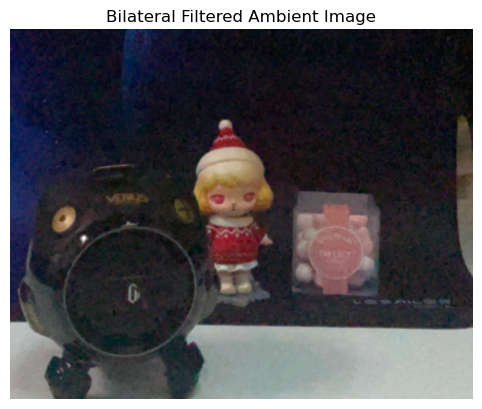

In [35]:
plt.imshow(out)  
plt.title('Bilateral Filtered Ambient Image')  
plt.axis('off')  
plt.show()

####  1.2 Joint bilateral filtering


In [36]:
diff = np.abs(out_jbf - im1) * 5

# Figure ve axes oluştur
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# İlk görsel: fark görüntüsü
axs[0].imshow(diff)
axs[0].axis('off')
axs[0].set_title('Difference Image', fontsize=12)

# İkinci görsel: joint bilateral filtering sonucu
axs[1].imshow(out_jbf)
axs[1].axis('off')
axs[1].set_title('Joint Bilateral Filter Output', fontsize=12)

# Aralarındaki boşluğu daralt
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


####  1.3 Detail Transfer


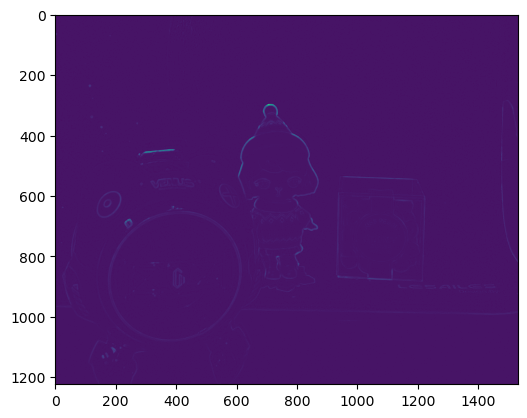

In [45]:
im1 = io.imread('data/camera/nonflash/1.jpg')
A = (im1-im1.min())/(im1.max()-im1.min())
im2 = io.imread('data/camera/flash/1.jpg')
F = (im2-im2.min())/(im2.max()-im2.min())
A_NR = JointBilateral(A[...,0], F[...,0], sigma_r=0.25, sigma_s=2)
F_base = PiecewiseBilateral(F[..., 0], sigma_r=0.25, sigma_s=2)
A_detail = detail_transfer(A_NR, F[..., 0], F_base)
plt.imshow(A_detail - A[..., 0])

In [55]:

im1 = io.imread('data/camera/nonflash/1.jpg')
im_am = (im1-im1.min())/(im1.max()-im1.min())
im2 = io.imread('data/camera/flash/1.jpg')
im_f = (im2-im2.min())/(im2.max()-im2.min())
im_masked, M, *others = masking(im_f, im_am)
out_detail, *others = detail_transfer1(im_f, im_am)
out_detail = np.clip(out_detail, 0, 1)

diff_dt = np.abs(im_masked-out_detail)*5
plt.imshow(diff_dt)
plt.axis('off')
plt.savefig('masking_diff.png', bbox_inches='tight', pad_inches=0.0, dpi=200)

(3, 1224, 1532, 3)
(5, 1224, 1532, 3)
(5, 1224, 1532, 3)
(3, 1224, 1532, 3)
(5, 1224, 1532, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


####  1.4 Masked Detail Transfer


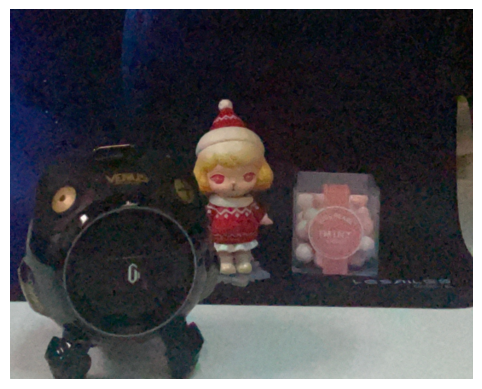

In [60]:
im_masked_uint8 = np.clip(im_masked * 255, 0, 255).astype(np.uint8)

# Display the image using matplotlib
plt.imshow(im_masked_uint8)
plt.axis('off')  # Optional: Hide axes
plt.show()

# Save the image using skimage
io.imsave('masked.png', im_masked_uint8)

When testing the bilateral filter, I noticed that using a smaller value for σr caused color shifts, making some pixels appear too bright. I also realized that important details were lost when noise and image content weren’t clearly separated.

The value of σs had a big effect on the sharpness of the image edges. A larger σs made the edges sharper, while a smaller σs kept the image sharper overall but reduced edge sharpness.

This shows that while the bilateral filter reduced noise, some bright pixels remained. The slow speed of the algorithm limited the ability to experiment with different settings to improve the results.

#### 2. Gradient-domain processing 

In [7]:
def grad_x(im):
    imx = np.pad(im, ((0,0), (1,0)))
    gr_x = np.diff(imx, n=1, axis=1)
    return gr_x

def grad_y(im):
    imy = np.pad(im, ((1,0),(0,0)))
    gr_y = np.diff(imy, n=1, axis=0)
    return gr_y

def get_gradient(im):

    gr_x = grad_x(im)
    gr_y = grad_y(im)
    gr = np.stack([gr_x, gr_y], axis=0) #H,W,2

    return gr

def initialize_input(I, del_target):
    I_init_star = np.zeros_like(I)
    D = divergence(del_target)
    B = np.zeros_like(I)
    B[1:-1, 1:-1] = 1
    I_boundary = np.copy(I)
    I_boundary[1:-1, 1:-1] = 0

    return I_init_star, D, B, I_boundary
def img_gradient(im):

    gx = get_gradient(im[:,:,0])
    gy = get_gradient(im[:,:,1])
    gz = get_gradient(im[:,:,2])

    out = np.stack([gx, gy, gz], axis=3) #2,H,W,3
    return out

def img_divergence(im):

    im_grad = img_gradient(im) #2,H,W,3
    
    div_x = divergence(im_grad[:,:,:,0])
    div_y = divergence(im_grad[:,:,:,1])
    div_z = divergence(im_grad[:,:,:,2])

    out = np.stack([div_x, div_y, div_z], axis=2)

    return out

def CGD(I_init_star, D, B, I_boundary, eps=1e-6, N=1000):
    # Initialization
    I_star = B * I_init_star + (1 - B) * I_boundary
    r = B * (D - laplacian(I_star))
    d = r
    delta_new = np.dot(r.flatten(), r.flatten())
    n = 0

    # Gradient descent
    while np.sqrt(np.dot(r.flatten(), r.flatten())) > eps and n < N:
        q = laplacian(d)
        eta = delta_new / np.dot(d.flatten(), q.flatten())
        I_star += B * (eta * d)
        r = B * (r - (eta * q))
        delta_old = delta_new
        delta_new = np.dot(r.flatten(), r.flatten())
        beta = delta_new / delta_old
        d = r + (beta * d)
        n += 1

    return I_star


def gradient(I):
    gx = np.diff(I, axis=1, prepend=0)
    gy = np.diff(I, axis=0, prepend=0)
    return np.dstack((gx, gy))

def divergence(delta):
    Gx, Gy = delta[...,0], delta[...,1]
    dx = np.pad(Gx[:,1:] - Gx[:,:-1], ((0,0),(0,1)), mode='edge')
    dy = np.pad(Gy[1:,:] - Gy[:-1,:], ((0,1),(0,0)), mode='edge')
    div = dx + dy
    return div

def laplacian(I):
    kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    lap = signal.convolve2d(I, kernel, mode='same', boundary='symm')
    return lap
    
def laplacian_image(img):
    laplacian0 = laplacian(img[:, :, 0])
    laplacian1 = laplacian(img[:, :, 1])
    laplacian2 = laplacian(img[:, :, 2])
    return np.stack([laplacian0, laplacian1, laplacian2], axis=2)
    
def initialize_input(I, del_target):
    I_init_star = np.zeros_like(I)
    D = divergence(del_target)
    B = np.zeros_like(I)
    B[1:-1, 1:-1] = 1
    I_boundary = np.copy(I)
    I_boundary[1:-1, 1:-1] = 0

    return I_init_star, D, B, I_boundary

In [8]:
def poisson_solver(D, img, I_star_init, EPSILON=1e-5, N=10000):

    B = np.zeros(img.shape)
    B[1:-1,1:-1,:] = 1

    I_star_b = np.zeros_like(img)
    I_star_b[1:-1,1:-1,:] = img[1:-1,1:-1,:]

    I_star = B*I_star_init + (1-B)*I_star_b
    r = B*(D-laplacian_image(I_star))
    d = r
    delta_new = np.sum(r*r)
    n = 0

    while(n<N and delta_new>EPSILON):
       if(n % 1000 == 0):
            
            
        q = laplacian_image(d)
        alpha = delta_new/np.sum(d*q)
        I_star = I_star + alpha*(B*d)
        r = B*(r - alpha*q)
        delta_old = delta_new
        delta_new = np.sum(r*r)
        beta = delta_new/delta_old
        d = r + beta*d
        n += 1
    
    I_star = np.clip(I_star, 0, 1)
    return I_star

In [4]:
A = (io.imread('data/face/nonflash/10.png') / 255).astype(np.float32)      # ambient image
F = (io.imread('data/face/flash/10.png') / 255).astype(np.float32)        # flash image
eps_list = [0.00001]
N_list = [1000]


In [5]:
def compute_gradient(alpha, phi):
    del_a = gradient(alpha)
    del_phi = gradient(phi)

    return del_a, del_phi
    
def calculate_M(del_a, del_phi):
    a_x, a_y = del_a[...,0], del_a[...,1]
    phi_x, phi_y = del_phi[...,0], del_phi[...,1]

    numerator = np.abs(phi_x * a_x + phi_y * a_y)
    denominator = np.sqrt(phi_x ** 2 + phi_y ** 2) * np.sqrt(a_x ** 2 + a_y ** 2)
    M = numerator / (denominator + 1e-9)
    return M
    
def saturation_weight_map(phi, t_s, sigma):
    ws = np.tanh(sigma * (phi - t_s))
    return ws

def normalize_map(ws):
    return 0.5 * (ws + 1)
    
def fuse_image(del_a, del_phi, M, ws):
    a_x, a_y = del_a[...,0], del_a[...,1]
    phi_x, phi_y = del_phi[...,0], del_phi[...,1]

    del_phi_star = np.zeros_like(del_a)
    del_phi_star[:,:,0] = ws * a_x + (1 - ws) * (M * phi_x + (1-M) * a_x)
    del_phi_star[:,:,1] = ws * a_y + (1 - ws) * (M * phi_y + (1-M) * a_y)

    return del_phi_star
    
def compute_gradient_field(alpha, phi, t_s, sigma):
    del_a = gradient(alpha)
    del_phi = gradient(phi)

    M = calculate_M(del_a, del_phi)
    ws = saturation_weight_map(phi, t_s, sigma)
    norm_ws = normalize_map(ws)
    del_phi_star = fuse_image(del_a, del_phi, M, norm_ws)

    return del_phi_star


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


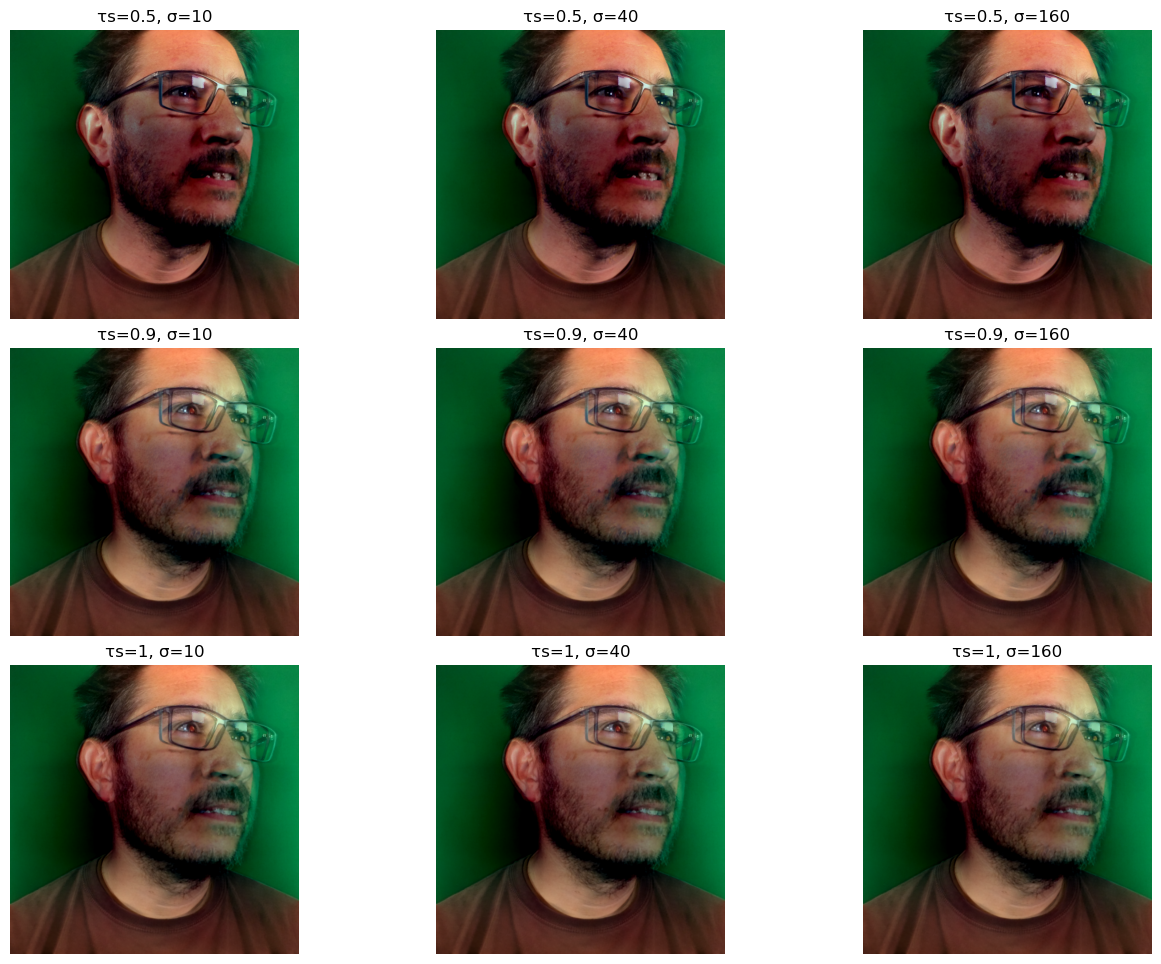

In [16]:
tao_list = [0.5, 0.9, 1]
sigma_list = [10, 40, 160]

fig, axes = plt.subplots(len(tao_list), len(sigma_list), figsize=(16, 12))
for i in range(len(tao_list)):
    for j in range(len(sigma_list)):
        fused_image = np.zeros_like(A)
        for c in range(A.shape[-1]):
            alpha = A[..., c]
            phi = F[..., c]
            del_phi_star = compute_gradient_field(alpha, phi, t_s=tao_list[i], sigma=sigma_list[j]) # Recommended t and sigma values.
            I_init_star, D, B, I_boundary = initialize_input(alpha, del_phi_star)
            fused_image[..., c] = CGD(I_init_star, D, B, I_boundary, eps=1e-05, N=1000)

       
        axes[i,j].imshow(fused_image)
        axes[i, j].set_title(f'τs={tao_list[i]}, σ={sigma_list[j]}')
        axes[i, j].axis('off')

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


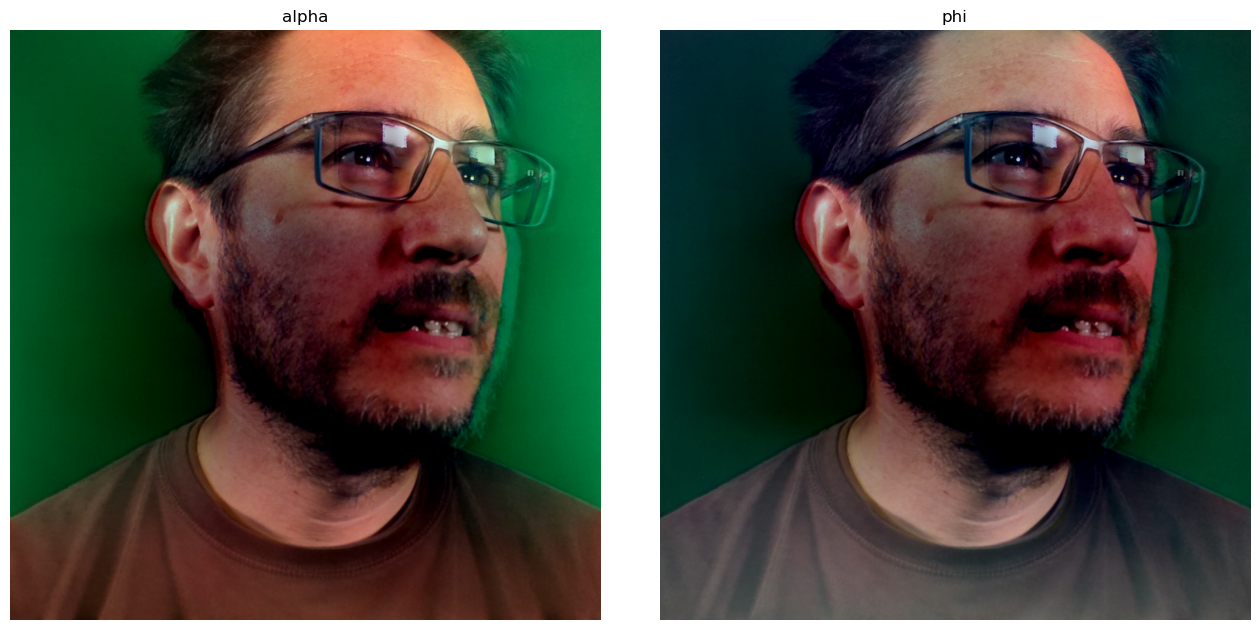

In [17]:
fused_image1 = np.zeros_like(A)
fused_image2 = np.zeros_like(A)
for c in range(A.shape[-1]):
    alpha = A[..., c]
    phi = F[..., c]
    del_phi_star = compute_gradient_field(alpha, phi, t_s=0.5, sigma=40)

    I_init_star, D, B, I_boundary = initialize_input(alpha, del_phi_star)
    fused_image1[..., c] = CGD(I_init_star, D, B, I_boundary, eps=0.001, N=1000)

    I_init_star, D, B, I_boundary = initialize_input(phi, del_phi_star)
    fused_image2[..., c] = CGD(I_init_star, D, B, I_boundary, eps=0.001, N=1000)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(fused_image1)
axes[0].set_title('alpha')
axes[0].axis('off')

axes[1].imshow(fused_image2)
axes[1].set_title('phi')
axes[1].axis('off')

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
fused_image1_uint8 = np.clip(fused_image1 * 255, 0, 255).astype(np.uint8)
fused_image2_uint8 = np.clip(fused_image2 * 255, 0, 255).astype(np.uint8)

# Görüntüleri dosyaya kaydet
io.imsave('fused_image1.png', fused_image1_uint8)
io.imsave('fused_image2.png', fused_image2_uint8)

In the fused images, the parameter τs controls how strong the flash effect is. Increasing τs makes the flash-lit areas brighter, but it can also cause blurring and loss of detail.

I also found that using the flash image as the starting point for the boundary conditions made the final image brighter, which I think gave better overall results.

#### 3. Capture your own flash/no-flash pairs

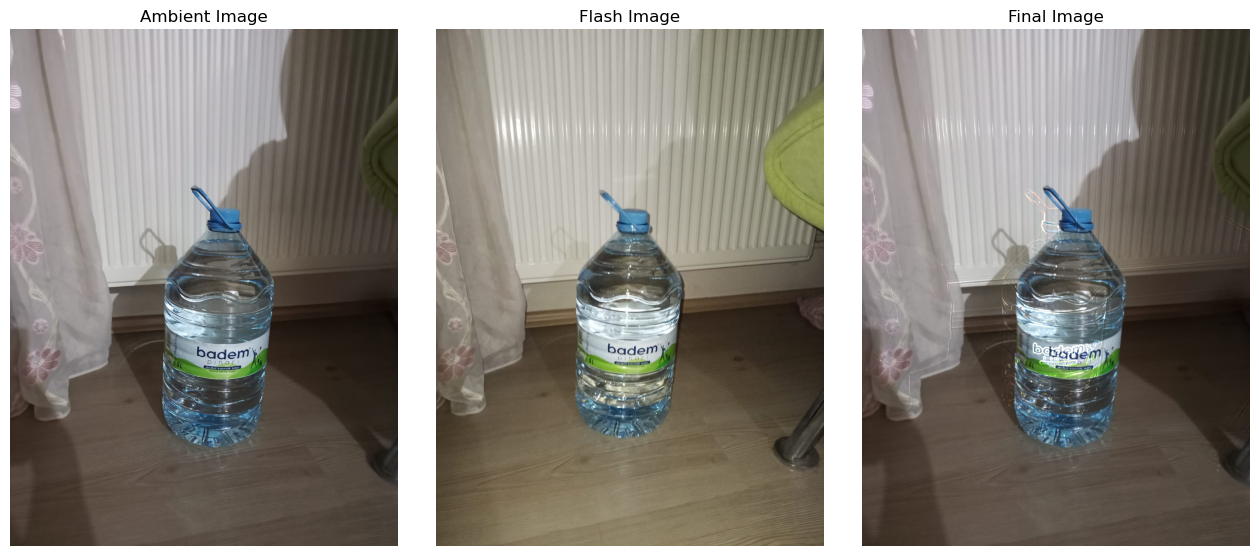

In [20]:
A = (io.imread('ambienttest.jpeg') / 255).astype(np.float32)
F = (io.imread('flashtest.jpeg') / 255).astype(np.float32)
final_image = bilateral_filtering_pipeline(F, A, 0.25, 2, t_shadow=0.25)
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
axes[0].imshow(A)
axes[0].set_title('Ambient Image')
axes[0].axis('off')

axes[1].imshow(F)
axes[1].set_title('Flash Image')
axes[1].axis('off')

axes[2].imshow(final_image)
axes[2].set_title('Final Image')
axes[2].axis('off')

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
asd = np.clip(final_image * 255, 0, 255).astype(np.uint8)

# Görüntüleri dosyaya kaydet
io.imsave('finalown.png', asd)